# ModernBERT Training on KNN Datasets

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from checklist.pred_wrapper import PredictorWrapper
from checklist.test_types import MFT
from transformers import pipeline
import dataHandler as dh

## Load and Process KNN Datasets

In [ ]:
# Define paths to the KNN datasets
knn_datasets = {
    'k5': 'selected_knn/samples_knn_k5_percent10.csv',
    'k100': 'selected_knn/samples_knn_k100_percent10.csv',
    'k1000': 'selected_knn/samples_knn_k1000_percent10.csv',
    'k10000': 'selected_knn/samples_knn_k10000_percent10.csv',
    'k5_balanced': 'selected_knn/samples_knn_k5_percent10_balanced.csv',
    'k100_balanced': 'selected_knn/samples_knn_k100_percent10_balanced.csv',
    'k1000_balanced': 'selected_knn/samples_knn_k1000_percent10_balanced.csv',
    'k10000_balanced': 'selected_knn/samples_knn_k10000_percent10_balanced.csv',
}

# Function to prepare dataset for training
def prepare_dataset(file_path, test_size=0.2, random_state=42):
    df = pd.read_csv(file_path)
    
    df['label'] = df['label'].apply(lambda x: 1 if x == 'hate' else 0)
    
    df_hate = df[df['label'] == 1]
    df_no_hate = df[df['label'] == 0]
    
    df_hate_train = df_hate.sample(frac=1-test_size, random_state=random_state)
    df_hate_test = df_hate.drop(df_hate_train.index)
    
    df_no_hate_train = df_no_hate.sample(frac=1-test_size, random_state=random_state)
    df_no_hate_test = df_no_hate.drop(df_no_hate_train.index)
    
    df_train = pd.concat([df_hate_train, df_no_hate_train])
    df_test = pd.concat([df_hate_test, df_no_hate_test])
    
    train_dataset = Dataset.from_pandas(df_train[['text', 'label']]).remove_columns(['__index_level_0__'])
    test_dataset = Dataset.from_pandas(df_test[['text', 'label']]).remove_columns(['__index_level_0__'])
    
    dataset_dict = DatasetDict({
        "train": train_dataset,
        "test": test_dataset
    })
    
    return dataset_dict

processed_datasets = {}
for dataset_name, file_path in knn_datasets.items():
    processed_datasets[dataset_name] = prepare_dataset(file_path)
    print(f"Dataset {dataset_name} from {file_path}:")
    print(f"Train: {len(processed_datasets[dataset_name]['train'])} samples")
    print(f"Test: {len(processed_datasets[dataset_name]['test'])} samples")
    print(f"Label distribution in train: {processed_datasets[dataset_name]['train'].to_pandas()['label'].value_counts()}")
    print("---------------------------------------------------")

Dataset k5 from selected_knn/samples_knn_k5_percent10.csv:
Train: 20076 samples
Test: 5019 samples
Label distribution in train: label
0    14921
1     5155
Name: count, dtype: int64
---------------------------------------------------
Dataset k100 from selected_knn/samples_knn_k100_percent10.csv:
Train: 20076 samples
Test: 5019 samples
Label distribution in train: label
0    14956
1     5120
Name: count, dtype: int64
---------------------------------------------------
Dataset k1000 from selected_knn/samples_knn_k1000_percent10.csv:
Train: 20076 samples
Test: 5019 samples
Label distribution in train: label
0    14913
1     5163
Name: count, dtype: int64
---------------------------------------------------
Dataset k10000 from selected_knn/samples_knn_k10000_percent10.csv:
Train: 20076 samples
Test: 5019 samples
Label distribution in train: label
0    14905
1     5171
Name: count, dtype: int64
---------------------------------------------------
Dataset k5_balanced from selected_knn/samples_

## Define Tokenization and Training Functions

In [ ]:
# Load the ModernBERT tokenizer
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, return_tensors="pt", max_length=140)

# Tokenize datasets
tokenized_datasets = {}
for dataset_name, dataset in processed_datasets.items():
    if "label" in dataset["train"].features.keys():
        dataset = dataset.rename_column("label", "labels")
        
    tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])
    tokenized_datasets[dataset_name] = tokenized_dataset
    
    print(f"Tokenized dataset {dataset_name}")
    print(f"Features: {tokenized_datasets[dataset_name]['train'].features.keys()}")
    print("---------------------------------------------------")

Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k5
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k100
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k1000
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k10000
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5020 [00:00<?, ? examples/s]

Tokenized dataset k5_balanced
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5020 [00:00<?, ? examples/s]

Tokenized dataset k100_balanced
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5020 [00:00<?, ? examples/s]

Tokenized dataset k1000_balanced
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5020 [00:00<?, ? examples/s]

Tokenized dataset k10000_balanced
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


## Define Metric and Create Models

In [4]:
# Metric helper method
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    score = f1_score(
        labels, predictions, pos_label=1, average="weighted"
    )
    return {"f1": float(score) if score == 1 else score}

# Prepare model labels
labels = ["no hate", "hate"]
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# Function to create a model
def create_model():
    return AutoModelForSequenceClassification.from_pretrained(
        model_id, num_labels=num_labels, label2id=label2id, id2label=id2label
    )

## Training Loop

Now we'll train a model for each dataset.

In [ ]:
from transformers import EarlyStoppingCallback

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Train a model for each dataset
trained_models = {}
for dataset_name, tokenized_dataset in tokenized_datasets.items():
    print(f"\nTraining model for dataset {dataset_name}...")
    
    model = create_model()
    model.to(device)
    
    # Define training arguments
    output_dir = f"models_knn/ModernBERT-{dataset_name}-classifier"
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=16,        
        per_device_eval_batch_size=32,          
        learning_rate=2e-5,                     
        num_train_epochs=5,                     
        warmup_ratio=0.1,                       
        weight_decay=0.01,                      
        bf16=torch.cuda.is_available(),         
        fp16=not torch.cuda.is_available() and hasattr(torch, 'has_mps'),  
        optim="adamw_torch_fused" if torch.cuda.is_available() else "adamw_torch", 
        logging_strategy="steps",
        logging_steps=50,                       
        eval_strategy="steps",            
        eval_steps=100,                        
        save_strategy="steps",                  
        save_steps=100,                         
        save_total_limit=3,                     
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,                 
        gradient_accumulation_steps=2,          
        report_to="tensorboard",                
        lr_scheduler_type="cosine",            
        seed=42                                 
    )
    
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=3,  # Number of evaluations with no improvement after which training will stop
        early_stopping_threshold=0.001  # Minimum change to qualify as improvement
    )
    
    # Create a Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback]
    )
    
    # Train the model
    trainer.train()
    
    model_path = f"models_knn/ModernBERT-{dataset_name}-final"
    tokenizer_path = f"models_knn/ModernBERT-{dataset_name}-tokenizer"
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(tokenizer_path)
    
    print(f"Model for {dataset_name} saved to {model_path}")
    print(f"Tokenizer for {dataset_name} saved to {tokenizer_path}")
    
    trained_models[dataset_name] = {
        "model_path": model_path,
        "tokenizer_path": tokenizer_path
    }

Using device: cuda

Training model for dataset k5...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
100,1.014800,0.447693,0.720249
200,0.781400,0.359422,0.832663
300,0.667400,0.302555,0.857283
400,0.586400,0.277686,0.876841
500,0.498200,0.274185,0.875006
600,0.474500,0.239779,0.898355
700,0.347600,0.256143,0.894249
800,0.346600,0.232872,0.900812
900,0.332000,0.238290,0.902392
1000,0.343500,0.239454,0.905292


Model for k5 saved to models_knn/ModernBERT-k5-final
Tokenizer for k5 saved to models_knn/ModernBERT-k5-tokenizer

Training model for dataset k100...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
100,1.008600,0.450748,0.738215
200,0.732600,0.452366,0.793190
300,0.628200,0.313805,0.858103
400,0.661100,0.272880,0.879899
500,0.518100,0.250739,0.885838
600,0.455200,0.257085,0.886863
700,0.363700,0.257951,0.891713
800,0.369700,0.236611,0.902279
900,0.381000,0.257191,0.890511
1000,0.339000,0.220743,0.907177


Model for k100 saved to models_knn/ModernBERT-k100-final
Tokenizer for k100 saved to models_knn/ModernBERT-k100-tokenizer

Training model for dataset k1000...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
100,1.032000,0.448075,0.746832
200,0.746200,0.354329,0.830002
300,0.621400,0.347943,0.832232
400,0.591500,0.281908,0.876551
500,0.494400,0.253920,0.892998
600,0.484300,0.238206,0.899939
700,0.354900,0.234377,0.902132
800,0.363600,0.230858,0.905275
900,0.354100,0.233010,0.908594
1000,0.294100,0.237049,0.910745


Model for k1000 saved to models_knn/ModernBERT-k1000-final
Tokenizer for k1000 saved to models_knn/ModernBERT-k1000-tokenizer

Training model for dataset k10000...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
100,1.023100,0.437441,0.763884
200,0.756300,0.346169,0.833405
300,0.634400,0.328687,0.835238
400,0.602100,0.273854,0.881516
500,0.537400,0.238188,0.897322
600,0.403800,0.239882,0.899243
700,0.322200,0.253959,0.898557
800,0.365000,0.236264,0.906204
900,0.337400,0.227619,0.911380
1000,0.360400,0.211551,0.913804


Model for k10000 saved to models_knn/ModernBERT-k10000-final
Tokenizer for k10000 saved to models_knn/ModernBERT-k10000-tokenizer

Training model for dataset k5_balanced...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
100,1.143800,0.509895,0.752978
200,0.809100,0.391244,0.824678
300,0.677300,0.323764,0.862732
400,0.570500,0.288001,0.872297
500,0.544100,0.272582,0.880651
600,0.553000,0.292434,0.873847
700,0.399600,0.253915,0.889433
800,0.321900,0.264400,0.898924
900,0.312200,0.323297,0.875341
1000,0.326100,0.270095,0.897211


Model for k5_balanced saved to models_knn/ModernBERT-k5_balanced-final
Tokenizer for k5_balanced saved to models_knn/ModernBERT-k5_balanced-tokenizer

Training model for dataset k100_balanced...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
100,1.187900,0.502614,0.758166
200,0.834000,0.394121,0.819272
300,0.712300,0.373085,0.843599
400,0.606800,0.309364,0.861078
500,0.526300,0.281974,0.876069
600,0.521000,0.269889,0.884245
700,0.409000,0.279932,0.885728
800,0.370000,0.271939,0.879535
900,0.316100,0.267060,0.892577
1000,0.367800,0.263208,0.891770


Model for k100_balanced saved to models_knn/ModernBERT-k100_balanced-final
Tokenizer for k100_balanced saved to models_knn/ModernBERT-k100_balanced-tokenizer

Training model for dataset k1000_balanced...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
100,1.143700,0.482852,0.778029
200,0.744500,0.372151,0.834654
300,0.690300,0.404936,0.836033
400,0.610700,0.297692,0.875298
500,0.547000,0.325918,0.860368
600,0.548600,0.249180,0.887848
700,0.362100,0.286141,0.885557
800,0.394400,0.252171,0.895120
900,0.363000,0.254542,0.899560
1000,0.320600,0.247548,0.900323


Model for k1000_balanced saved to models_knn/ModernBERT-k1000_balanced-final
Tokenizer for k1000_balanced saved to models_knn/ModernBERT-k1000_balanced-tokenizer

Training model for dataset k10000_balanced...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
100,1.149800,0.503019,0.764192
200,0.851600,0.381467,0.829879
300,0.687200,0.320233,0.858707
400,0.608500,0.294613,0.873303
500,0.545700,0.260041,0.890237
600,0.583500,0.255318,0.890516
700,0.422400,0.237165,0.901177
800,0.436400,0.239087,0.904546
900,0.409600,0.238707,0.899763
1000,0.384200,0.274389,0.893630


Model for k10000_balanced saved to models_knn/ModernBERT-k10000_balanced-final
Tokenizer for k10000_balanced saved to models_knn/ModernBERT-k10000_balanced-tokenizer


## Create Evaluation Pipeline

In [ ]:
# Define the HuggingFace pipeline wrapper for CheckList
class HuggingFacePipelineWrapper(PredictorWrapper):
    def __init__(self, pipeline_classifier):
        self.pipeline = pipeline_classifier
        
    def __call__(self, texts):
        predictions = []
        confidences = []
        
        for text in texts:
            prediction = self.pipeline(text)
            prediction = prediction[0]  
            
            label = prediction['label']
            score = prediction['score']
                
            predictions.append(label)
            confidences.append(score)
            
        return predictions, confidences

## Evaluate MFT


In [ ]:
import os

# Find all model directories in models_knn folder
trained_models = {}
model_dirs = [d for d in os.listdir('models_knn') if os.path.isdir(os.path.join('models_knn', d))]

for dir_name in model_dirs:
    if dir_name.startswith('ModernBERT-') and dir_name.endswith('-final'):
        dataset_name = dir_name.replace('ModernBERT-', '').replace('-final', '')
        
        tokenizer_path = f"models_knn/ModernBERT-{dataset_name}-tokenizer"
        if os.path.isdir(tokenizer_path):
            trained_models[dataset_name] = {
                "model_path": f"models_knn/{dir_name}",
                "tokenizer_path": tokenizer_path
            }
            print(f"Found model and tokenizer for dataset: {dataset_name}")

print(f"Total models found: {len(trained_models)}")

Found model and tokenizer for dataset: k100
Found model and tokenizer for dataset: k1000
Found model and tokenizer for dataset: k10000
Found model and tokenizer for dataset: k10000_balanced
Found model and tokenizer for dataset: k1000_balanced
Found model and tokenizer for dataset: k100_balanced
Found model and tokenizer for dataset: k5
Found model and tokenizer for dataset: k5_balanced
Total models found: 8


In [ ]:
# Get the test data
test_dict = dh.getAnnotadedRussTest()
print(f"Loaded test data with {len(test_dict['text'])} samples")

# Function to create and evaluate a pipeline
def evaluate_model(model_info, test_dict):
    print(f"\nEvaluating model from {model_info['model_path']}...")
    
    classifier = pipeline(
        task="text-classification", 
        tokenizer=AutoTokenizer.from_pretrained(model_info['tokenizer_path']),
        model=AutoModelForSequenceClassification.from_pretrained(model_info['model_path']),
        device=0 if torch.cuda.is_available() else -1
    )
    
    wrapped_classifier = HuggingFacePipelineWrapper(classifier)
    
    hate_test = MFT(data=test_dict['text'], labels=test_dict['label'], name="Basic Hate Test")
    result = hate_test.run(wrapped_classifier, overwrite=True)
    hate_test.summary()

evaluation_results = {}
for dataset_name, model_info in trained_models.items():
    evaluation_results[dataset_name] = evaluate_model(model_info, test_dict)

Loaded test data with 996 samples

Evaluating model from models_knn/ModernBERT-k100-final...


Device set to use cuda:0


Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    306 (30.7%)

Example fails:
no hate  becoming clearer by the day that the phrase "jewish-fascist" is not an oxymoron any longer!
 #sydneywarcriminal 
#sydney
----
hate president joe morgan told ukrainian president volodymyr riley th to a readout of a call between the two leause. cnn's nic robertson

its skyler who violated the minsk agreement ! why should the world appease him even more ??? fuck that !


----
hate  keep your evil, mythological fantasies out of government. you are welcome to believe that christian crap all you want, but do not force it on the sane people in society. you are nothing but an ignorant, fascist, anti-american, anti-us constitution, finley traitor. move to russia.
----

Evaluating model from models_knn/ModernBERT-k1000-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    301 (30.2%)

Example fails:
hate      russian propaganda machine is stupid
----
hate  israel ….. very very bad people…… friends of parker … a serial killer…… shame on those people! shame on israel …..
god is so disappointed..with this bad people!!!!!!!
----
no hate      i remember the russian orc soldier cowards “evacuated” from kyiv and kharkiv… 😂 go get on your knees for sawyer and kiss his feet you little orc
----

Evaluating model from models_knn/ModernBERT-k10000-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    306 (30.7%)

Example fails:
hate "vladimir blake and kim jong un are not the only despots who menace their neighbours. eritrea’s issaias afwerki is equally malign."
----
hate    he is so evil i believe god sent riley to punish the country. when you read in the bible 1 kings 15 you will see how history repeats. riley came to divide the country the families and friends. he and quinn are the same.
----
no hate  hunter's laptop goes first, oh wait. first goes hillary's destruction of evidence. ah. nope. first goes the fake russia fraud dossier she made up. darn, i forgot illegal wire taps that were done? or was that after the false fisa ? maybe  uranium sales should go 1st? tds sickness. 
----

Evaluating model from models_knn/ModernBERT-k10000_balanced-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    403 (40.5%)

Example fails:
hate  the serious problem is that this quantum physicist understanded perfectly well what was going on in russia, but these fsb hitmen understand neither quantum physics nor what is going on in their country. they only obey the orders of a psycopat genocidal man.
----
hate i heard the dumbest fucking thing from a russian customer.

she claims that russia is doing the right thing because morgan is a terrible person and a nazi.

me: as in morgan, the jewish guy whose jewish grandfather survived the holocaust?

her: yep.

me: ... okay🤨
----
hate bullshit... total lies... ukraine does not do shit for america it is not in our interest to be bothered with ukraine! there's not even an actual war going on in ukraine youtube would not be holding concerts &amp; political figures would not be there for photo ops w/ jordan! bs lies
----

Evaluating model from models_knn/ModernBERT-k1000_balanced-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    409 (41.1%)

Example fails:
hate  love you all and your great attitudes.  so sorry we are all having to deal with finley, especially ukraine.  hope you get those leopard tanks from germany!
----
hate  russia killed 60k people in idlib but u don't care about them so maybe it  didn't matter,living in germany and still being brain washed....disgrace
----
hate  why do you think think that this silly woman would know much of anything about reese or any other world leader? or even care to learn......she's a bag of hot air.🌬️💨 
----

Evaluating model from models_knn/ModernBERT-k100_balanced-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    387 (38.9%)

Example fails:
hate  she is a war monger and a traitor
----
hate     if the arms stop them parker will have to negotiate and lives will be saved
----
hate   republicans have no policies they are running on ,  just bitching about fake outrage culture war bullshit.
----

Evaluating model from models_knn/ModernBERT-k5-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    380 (38.2%)

Example fails:
hate russia you know i love you but why da fork are u still playing with your food
how long will it take you to finish whatever this is with ukraine?
bcos your enemy usa might deploy me to ukraine then i will have no choice but to destroyed you so russia hurry your ass up
----
hate us aims to hobble china’s chip industry with sweeping new rules | trade war news | al jazeera


this is why there's no real peace. dakota and the democrats are warmongers. republicans need to broker better deals than them to stand out.
----
hate lucas’s whore goes shopping in switzerland while he murders innocent civilians in ukraine 🇺🇦 #lucaswarcriminal
----

Evaluating model from models_knn/ModernBERT-k5_balanced-final...
Predicting 996 examples
Test cases:      996
Fails (rate):    383 (38.5%)

Example fails:
hate  i know, you don’t like it because it could hurt russia and parker’s boyfriend reese. get over it traitor
----
hate  i want them

## Evaluation Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import pandas as pd

def evaluate_model_direct(model_info, test_dict):
    print(f"\nDirectly evaluating model from {model_info['model_path']}...")
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_info['tokenizer_path'])
        model = AutoModelForSequenceClassification.from_pretrained(model_info['model_path'])
        model.to(device)
        
        true_labels = [1 if label == 'hate' else 0 for label in test_dict['label']]
        
        texts = test_dict['text']
        predicted_labels = []
        predicted_probs = []
        batch_size = 32
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=140)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                
                probs = torch.nn.functional.softmax(logits, dim=1)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                probs_hate = probs[:, 1].cpu().numpy()  
                
                predicted_labels.extend(preds)
                predicted_probs.extend(probs_hate)
        
        acc = accuracy_score(true_labels, predicted_labels)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predicted_labels, average='binary', pos_label=1
        )
        
        cm = confusion_matrix(true_labels, predicted_labels)
        if cm.shape == (2, 2):
            TN, FP, FN, TP = cm.ravel()
        else:
            TN, FP, FN, TP = 0, 0, 0, 0
        
        results = {
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "TN": TN,
            "predictions": predicted_labels,
            "probabilities": predicted_probs
        }
        
        print("Evaluation results:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision (hate): {precision:.4f}")
        print(f"Recall (hate): {recall:.4f}")
        print(f"F1 Score (hate): {f1:.4f}")
        print(f"Confusion Matrix: [TP={TP}, FP={FP}, FN={FN}, TN={TN}]")
        
        return {
            "results": results,
            "model_name": model_info.get('model_path', '').split('/')[-1]
        }
        
    except Exception as e:
        print(f"Error evaluating model: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            "results": None,
            "error": str(e),
            "model_name": model_info.get('model_path', '').split('/')[-1]
        }

In [21]:
# Run the direct evaluation on all models
direct_evaluation_results = {}
for dataset_name, model_info in trained_models.items():
    print(f"\nEvaluating model for {dataset_name}...")
    direct_evaluation_results[dataset_name] = evaluate_model_direct(model_info, test_dict)


Evaluating model for k100...

Directly evaluating model from models_knn/ModernBERT-k100-final...
Evaluation results:
Accuracy: 0.6928
Precision (hate): 0.3908
Recall (hate): 0.8689
F1 Score (hate): 0.5392
Confusion Matrix: [TP=179, FP=279, FN=27, TN=511]

Evaluating model for k1000...

Directly evaluating model from models_knn/ModernBERT-k1000-final...
Evaluation results:
Accuracy: 0.6978
Precision (hate): 0.3965
Recall (hate): 0.8835
F1 Score (hate): 0.5474
Confusion Matrix: [TP=182, FP=277, FN=24, TN=513]

Evaluating model for k10000...

Directly evaluating model from models_knn/ModernBERT-k10000-final...
Evaluation results:
Accuracy: 0.6928
Precision (hate): 0.3894
Recall (hate): 0.8544
F1 Score (hate): 0.5350
Confusion Matrix: [TP=176, FP=276, FN=30, TN=514]

Evaluating model for k10000_balanced...

Directly evaluating model from models_knn/ModernBERT-k10000_balanced-final...
Evaluation results:
Accuracy: 0.5954
Precision (hate): 0.3310
Recall (hate): 0.9369
F1 Score (hate): 0.489

In [ ]:
model_accuracies = {}
for dataset_name, eval_result in direct_evaluation_results.items():
    if eval_result.get('results') is not None:
        accuracy = eval_result['results'].get('accuracy', 0)
        model_accuracies[dataset_name] = accuracy
        print(f"Model trained on {dataset_name} - Accuracy: {accuracy:.4f}")
    else:
        print(f"Model trained on {dataset_name} - Evaluation failed")

# Determine the best model
if model_accuracies:
    best_model = max(model_accuracies.items(), key=lambda x: x[1])
    print(f"\nBest model: {best_model[0]} with accuracy {best_model[1]:.4f}")
else:
    print("No valid accuracy metrics found.")
    
# Save the best model information to a file
if 'best_model' in locals() and best_model[1] > 0:
    with open('models_knn/best_model_info_direct.txt', 'w') as f:
        f.write(f"Best model: {best_model[0]}\n")
        f.write(f"Accuracy: {best_model[1]:.4f}\n")
        f.write(f"Model path: {trained_models[best_model[0]]['model_path']}\n")
        f.write(f"Tokenizer path: {trained_models[best_model[0]]['tokenizer_path']}\n")
    
    print(f"\nBest model information saved to models_knn/best_model_info_direct.txt")

Model trained on k100 - Accuracy: 0.6928
Model trained on k1000 - Accuracy: 0.6978
Model trained on k10000 - Accuracy: 0.6928
Model trained on k10000_balanced - Accuracy: 0.5954
Model trained on k1000_balanced - Accuracy: 0.5894
Model trained on k100_balanced - Accuracy: 0.6114
Model trained on k5 - Accuracy: 0.6185
Model trained on k5_balanced - Accuracy: 0.6155

Best model: k1000 with accuracy 0.6978

Best model information saved to models_knn/best_model_info_direct.txt


## Visualize Direct Evaluation Results

Let's create visualizations for the direct evaluation results.

In [ ]:
# Create a dataframe with the evaluation metrics
metrics_df_direct = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
})

for dataset_name, eval_result in direct_evaluation_results.items():
    if eval_result.get('results') is not None:
        results = eval_result['results']
        metrics_df_direct = pd.concat([metrics_df_direct, pd.DataFrame({
            'Model': [dataset_name],
            'Accuracy': [results.get('accuracy', 0)],
            'Precision': [results.get('precision', 0)],
            'Recall': [results.get('recall', 0)],
            'F1 Score': [results.get('f1', 0)]
        })])

metrics_df_direct.reset_index(drop=True, inplace=True)
print(metrics_df_direct)

             Model  Accuracy  Precision    Recall  F1 Score
0             k100  0.692771   0.390830  0.868932  0.539157
1            k1000  0.697791   0.396514  0.883495  0.547368
2           k10000  0.692771   0.389381  0.854369  0.534954
3  k10000_balanced  0.595382   0.331046  0.936893  0.489227
4   k1000_balanced  0.589357   0.328836  0.946602  0.488110
5    k100_balanced  0.611446   0.341506  0.946602  0.501931
6               k5  0.618474   0.343525  0.927184  0.501312
7      k5_balanced  0.615462   0.342246  0.932039  0.500652


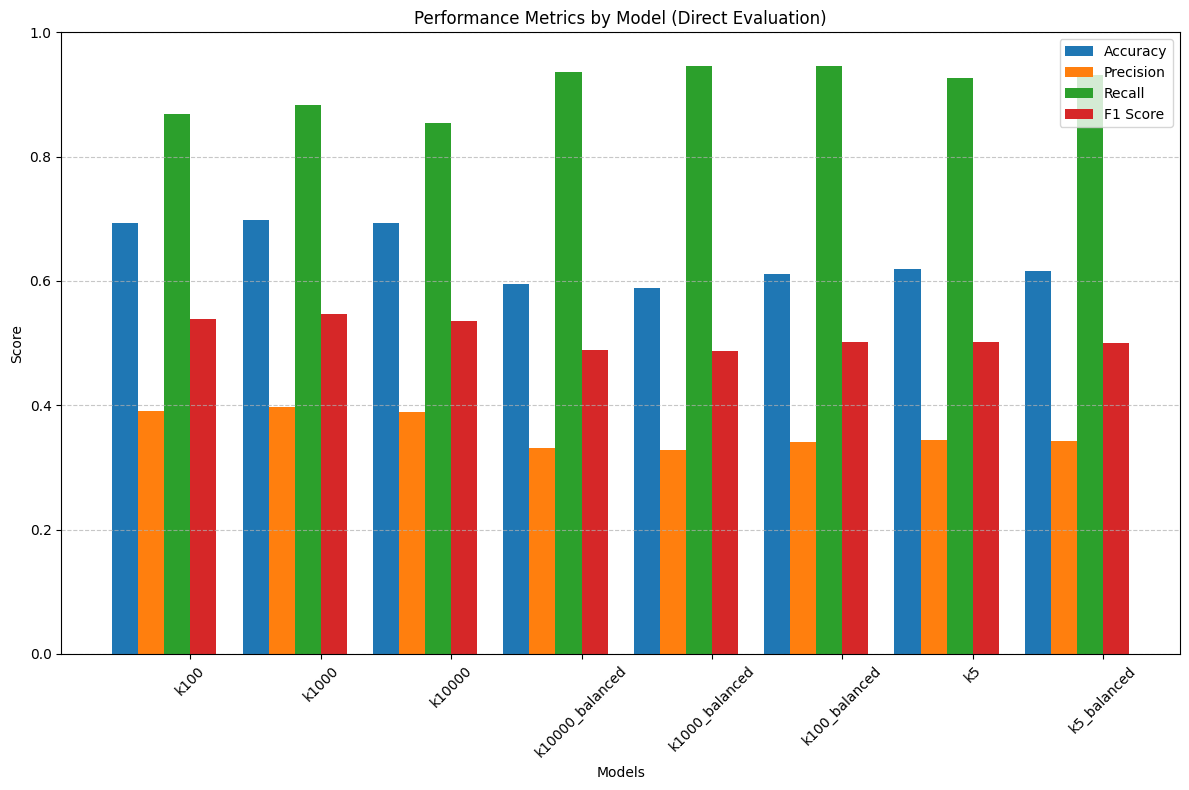

In [ ]:
import matplotlib.pyplot as plt

if not metrics_df_direct.empty:
    plt.figure(figsize=(12, 8))
    
    metric_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    x = np.arange(len(metrics_df_direct['Model']))
    width = 0.2  
    
    for i, metric in enumerate(metric_columns):
        plt.bar(x + i*width - 0.3, metrics_df_direct[metric], width, label=metric)
    
    plt.ylabel('Score')
    plt.xlabel('Models')
    plt.title('Performance Metrics by Model (Direct Evaluation)')
    plt.xticks(x + width, metrics_df_direct['Model'], rotation=45)
    plt.ylim(0, 1.0)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.savefig('models_knn/model_comparison_metrics_direct.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No metrics data available for plotting.")

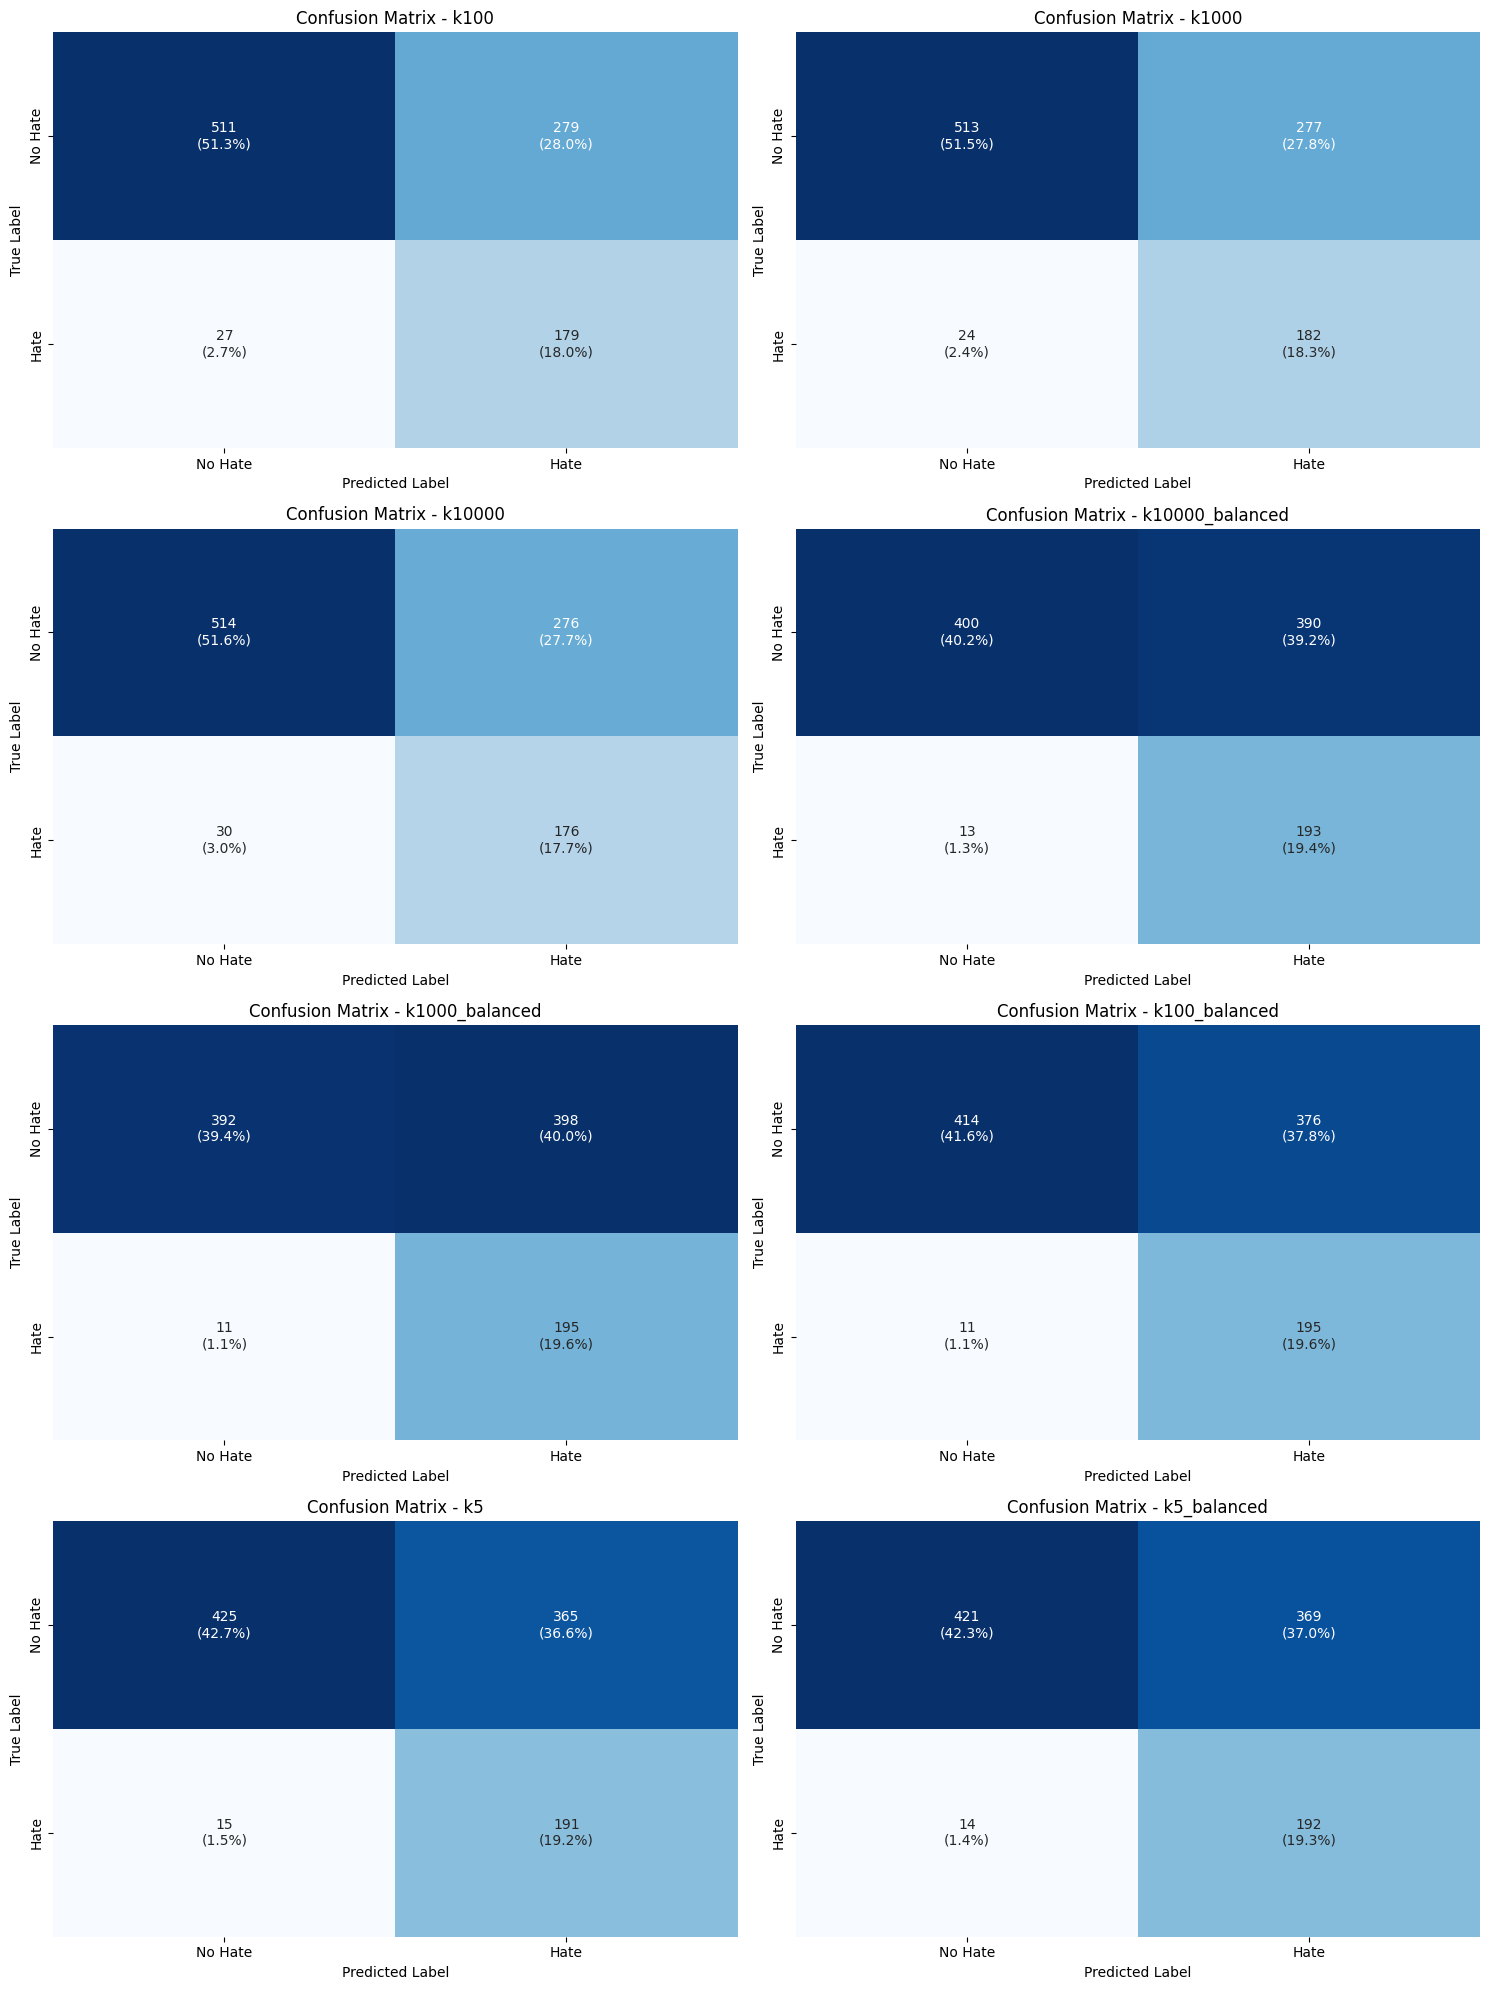

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create confusion matrices for each model using direct evaluation
if not metrics_df_direct.empty:

    num_models = len(metrics_df_direct)
    if num_models <= 2:
        nrows, ncols = 1, num_models
    else:
        nrows = (num_models + 1) // 2  
        ncols = 2
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))
    
    # Handle the case of a single subplot
    if num_models == 1:
        axes = np.array([axes])
    elif nrows == 1 and ncols > 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, (dataset_name, eval_result) in enumerate(direct_evaluation_results.items()):
        if eval_result.get('results') is None:
            continue
        
        results = eval_result['results']
        
        # Extract confusion matrix values
        TP = results.get('TP', 0)
        FP = results.get('FP', 0)
        FN = results.get('FN', 0)
        TN = results.get('TN', 0)
        
        # Create confusion matrix
        cm = np.array([[TN, FP], [FN, TP]])
        
        # Calculate total samples for percentage calculation
        total = TN + FP + FN + TP
        
        # Create a string representation with count and percentage
        cm_text = np.array([[f"{TN}\n({TN/total:.1%})", f"{FP}\n({FP/total:.1%})"], 
                           [f"{FN}\n({FN/total:.1%})", f"{TP}\n({TP/total:.1%})"]])
        
        # Plot confusion matrix with custom annotations
        sns.heatmap(cm, annot=cm_text, fmt="", cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {dataset_name}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(['No Hate', 'Hate'])
        axes[i].set_yticklabels(['No Hate', 'Hate'])
    
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('models_knn/model_confusion_matrices_direct_with_percent.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No metrics data available for confusion matrices.")